In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Loading 

In [2]:
sales_df = pd.read_csv('../datasets/predict-sales/sales_train.csv')
items_df = pd.read_csv('../datasets/predict-sales/items.csv')
test_df = pd.read_csv('../datasets/predict-sales/test.csv')

In [3]:
sales_df.drop(labels=['date'],inplace=True,axis=1)
sales_df = sales_df.reset_index()
items_df.drop(labels=['item_name'],inplace=True,axis=1)

In [ ]:
dict_aux = {}

In [ ]:
def setPair(x, d):
    i = str(x[0]) + '-' + str(x[1])
    try:
        return d[i]
    except:
        result = i
        d[i] = result
        return result

In [ ]:
sales_df['ID_pair'] = sales_df[['shop_id','item_id']].apply(setPair, args=[dict_aux], axis=1)

In [ ]:
sales_df = sales_df.merge(items_df)

In [ ]:
dict_aux = {}

In [ ]:
sales_df['ID_CAT_pair'] = sales_df[['shop_id','item_category_id']].apply(setPair, args=[dict_aux], axis=1)

In [ ]:
sales_df.info()

In [ ]:
sales_df.head()

In [ ]:
sales_df.to_csv('../datasets/predict-sales/sales_train_enriched.csv')

## Direct Load

In [4]:
sales_df = pd.read_csv('../datasets/predict-sales/sales_train_enriched.csv')

In [5]:
sales_df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

In [6]:
sales_df.head()

,index,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID_pair,item_category_id,ID_CAT_pair
0,0,0,59,22154,999.0,1.0,59-22154,37,59-37
1,3270,0,24,22154,999.0,1.0,24-22154,37,24-37
2,17081,0,27,22154,999.0,1.0,27-22154,37,27-37
3,25918,0,25,22154,999.0,1.0,25-22154,37,25-37
4,25919,0,25,22154,999.0,1.0,25-22154,37,25-37


# Visualizing Data 

Let's visualize some data from the test set:

In [7]:
def drawTimeSerie(df, sample, n):
    for i in range(n):
        shop_id = sample.iloc[i]['shop_id']
        item_id = sample.iloc[i]['item_id']
        id_df = df[(df['shop_id'] == shop_id) & (df['item_id'] == item_id)]
        id_df_grouped = id_df[['date_block_num','item_cnt_day']].groupby('date_block_num').sum().reset_index()
        plt.figure(figsize=[10,n*5])
        plt.subplot(n,1,i+1)
        plt.plot(id_df_grouped['date_block_num'], id_df_grouped['item_cnt_day'],'*-',)
        plt.title(str(shop_id) + '-' + str(item_id))

In [8]:
n_samples = 10
sample = test_df.sample(n=n_samples, axis=0)

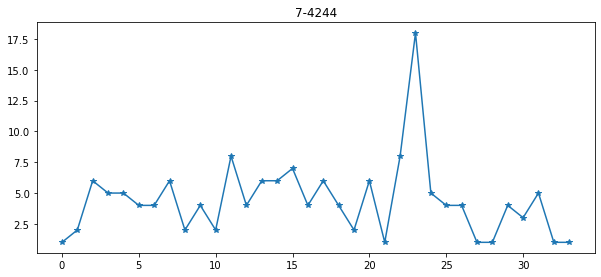

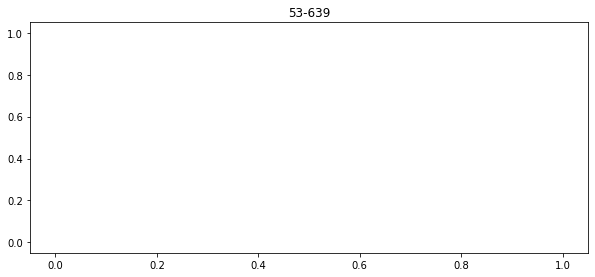

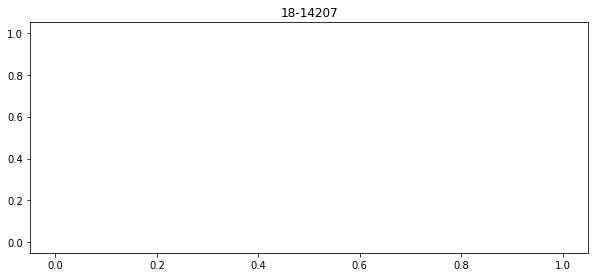

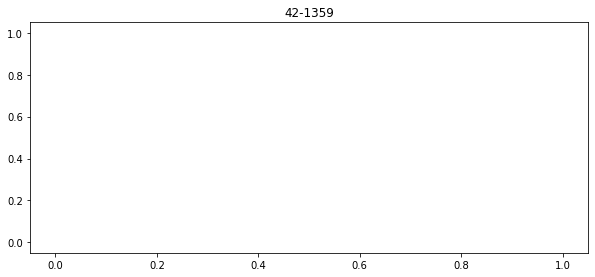

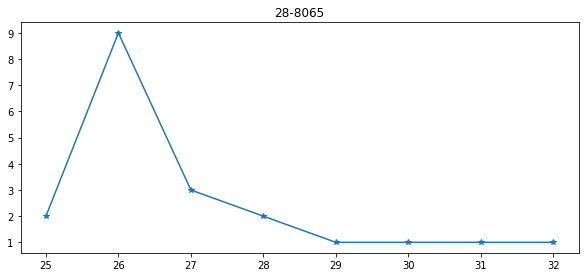

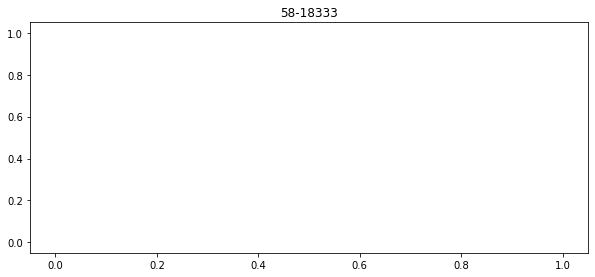

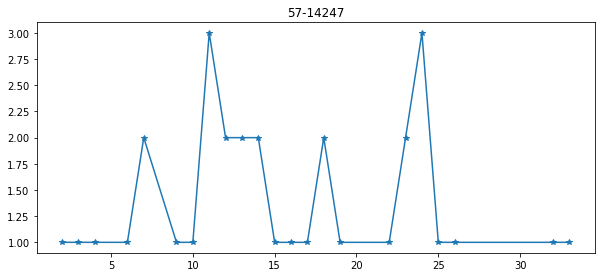

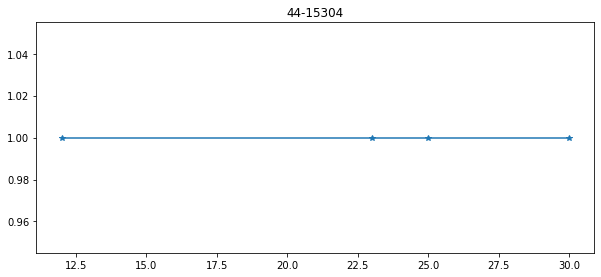

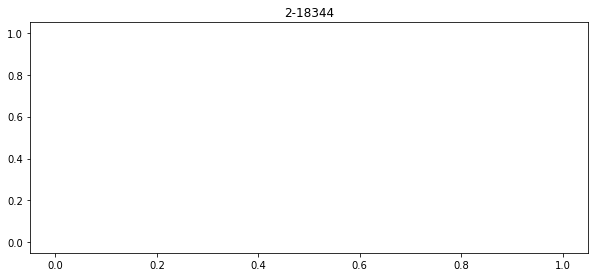

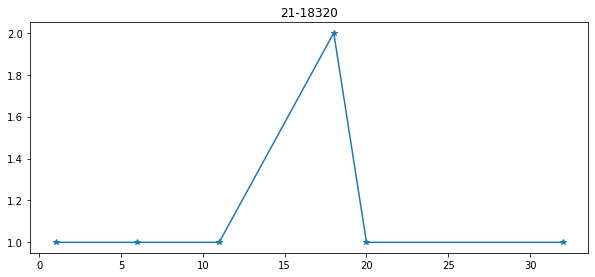

In [9]:
drawTimeSerie(sales_df, sample, n_samples)

# Preparing Data with FeatureTools (testing)

In [ ]:
import featuretools as ft

Let's evaluate the FT process 

## Pre-proccesing

In [ ]:
month_id = 9

In [ ]:
sales_month_df = sales_df[sales_df['date_block_num'] == month_id]

In [ ]:
sales_month_df.head()

In [ ]:
sales_month_df.drop(labels=['shop_id','item_id','item_category_id'], inplace=True, axis=1)

In [ ]:
sales_month_df.head()

## EntitySet Processing (Recommended by FeatureTools)

In [ ]:
es = ft.EntitySet(id="prediction_sales")

In [ ]:
es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_month_df, index='index')

In [ ]:
es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='idsCat',
                         index='ID_CAT_pair')

In [ ]:
feature_matrix_idsCat, feature_defs_idsCat = ft.dfs(entityset=es, target_entity='idsCat')

In [ ]:
feature_matrix_idsCat.info()

In [ ]:
idsCat = feature_matrix_idsCat.reset_index()

In [ ]:
idsCat_agg = idsCat[['ID_CAT_pair','SUM(sales.item_cnt_day)',
                     'MEAN(sales.item_cnt_day)','MEAN(sales.item_price)',
                     'STD(sales.item_cnt_day)','STD(sales.item_price)',
                     'MAX(sales.item_cnt_day)','MAX(sales.item_price)',
                     'MIN(sales.item_cnt_day)','MIN(sales.item_price)',
                     'SKEW(sales.item_cnt_day)','SKEW(sales.item_price)'
                    ]]

In [ ]:
idsCat_agg.columns = ['ID_CAT_pair','sum_shop_cat_sales',
                      'mean_shop_cat_day','mean_shop_cat_item_price',
                      'std_shop_cat_day','std_shop_cat_item_price',
                      'max_shop_cat_day','max_shop_cat_item_price',
                      'min_shop_cat_day','min_shop_cat_item_price',
                      'skew_shop_cat_day','skew_shop_cat_item_price',
                     ]

In [ ]:
idsCat_agg.head() 

Re-craete the EntitySet: 

In [ ]:
es = ft.EntitySet(id="prediction_sales")

In [ ]:
sales_month_df = sales_month_df.merge(idsCat_agg)

In [ ]:
sales_month_df.drop(labels=['ID_CAT_pair'], inplace=True, axis=1)

In [ ]:
es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_month_df, index='index')

In [ ]:
es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='ids',
                         index='ID_pair',
                         additional_variables=['date_block_num',
                                               'sum_shop_cat_sales',
                                               'mean_shop_cat_day',
                                               'mean_shop_cat_item_price',
                                               'std_shop_cat_day',
                                               'std_shop_cat_item_price',
                                               'max_shop_cat_day',
                                               'max_shop_cat_item_price',
                                               'min_shop_cat_day',
                                               'min_shop_cat_item_price',
                                               'skew_shop_cat_day',
                                               'skew_shop_cat_item_price'
                                              ]
                        )

In [ ]:
feature_matrix_ids, feature_defs_ids = ft.dfs(entityset=es, target_entity='ids')

In [ ]:
feature_matrix_ids.info()

In [ ]:
feature_matrix_ids.head()

# Generating the DataSet 

In [ ]:
slots = sales_df['date_block_num'].nunique()

In [ ]:
def generateFeatures(sales_df, months_feature, month_target):
    print('features window:',months_feature,', target:',month_target)
    # Step 1: Extract fetures from the previous point
    sales_window_df = sales_df[sales_df['date_block_num'].isin(months_feature)]
    sales_window_df.drop(labels=['shop_id','item_id','item_category_id'], inplace=True, axis=1)

    es = ft.EntitySet(id="prediction_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_window_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='idsCat',
                         index='ID_CAT_pair')
    feature_matrix_idsCat, feature_defs_idsCat = ft.dfs(entityset=es, target_entity='idsCat')
    idsCat = feature_matrix_idsCat.reset_index()
    idsCat_agg = idsCat[['ID_CAT_pair','SUM(sales.item_cnt_day)',
                     'MEAN(sales.item_cnt_day)','MEAN(sales.item_price)',
                     'STD(sales.item_cnt_day)','STD(sales.item_price)',
                     'MAX(sales.item_cnt_day)','MAX(sales.item_price)',
                     'MIN(sales.item_cnt_day)','MIN(sales.item_price)',
                     'SKEW(sales.item_cnt_day)','SKEW(sales.item_price)'
                    ]]
    idsCat_agg.columns = ['ID_CAT_pair','sum_shop_cat_sales',
                      'mean_shop_cat_day','mean_shop_cat_item_price',
                      'std_shop_cat_day','std_shop_cat_item_price',
                      'max_shop_cat_day','max_shop_cat_item_price',
                      'min_shop_cat_day','min_shop_cat_item_price',
                      'skew_shop_cat_day','skew_shop_cat_item_price',
                     ]
    
    sales_window_df = sales_window_df.merge(idsCat_agg)
    sales_window_df.drop(labels=['ID_CAT_pair'], inplace=True, axis=1)
    
    # Recreating EntitySet
    es = ft.EntitySet(id="prediction_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_window_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='ids',
                         index='ID_pair',
                         additional_variables=['date_block_num',
                                               'sum_shop_cat_sales',
                                               'mean_shop_cat_day',
                                               'mean_shop_cat_item_price',
                                               'std_shop_cat_day',
                                               'std_shop_cat_item_price',
                                               'max_shop_cat_day',
                                               'max_shop_cat_item_price',
                                               'min_shop_cat_day',
                                               'min_shop_cat_item_price',
                                               'skew_shop_cat_day',
                                               'skew_shop_cat_item_price'
                                              ]
                        )
    feature_matrix_ids, feature_defs_ids = ft.dfs(entityset=es, target_entity='ids')
    
    # Step 2: Extract target
    target = sales_df[sales_df['date_block_num'] == month_target][['ID_pair','item_cnt_day']].groupby('ID_pair').sum()    
    target.columns = ['target']
    
    return pd.concat([feature_matrix_ids, target], axis=1, sort=False)
    

In [ ]:
def slidingWindow(sales_df, size, slots):
    df_final = pd.DataFrame()
    for index in range(size,slots):
        features_target = generateFeatures(sales_df, np.arange(index-size,index),index)
        # TODO stack dataset
        df_final = pd.concat([df_final,features_target], axis=0) 
    # TODO return completed dataset
    return df_final

## Dataset Test

In [ ]:
dstest = slidingWindow(sales_df, 3,4)

In [ ]:
def fragment(df):
    num_rows = df.shape[0]
    num_mid = int(num_rows/2)
    d1 = df[0:num_mid]
    d2 = df[num_mid:num_rows]
    return d1, d2

## Dataset 1

In [ ]:
dataset1 = slidingWindow(sales_df, 3,slots)
dataset1A, dataset1B = fragment(dataset1)

In [ ]:
dataset1A.to_csv('../datasets/predict-sales/dataset1A.csv')
dataset1B.to_csv('../datasets/predict-sales/dataset1B.csv')

## Dataset 2

In [ ]:
dataset2 = slidingWindow(sales_df, 6,slots)
dataset2A, dataset2B = fragment(dataset2)

In [ ]:
dataset2A.to_csv('datasets/predict-sales/dataset2A.csv')
dataset2B.to_csv('datasets/predict-sales/dataset2B.csv')

## Dataset 3

In [ ]:
dataset3 = slidingWindow(sales_df, 9,slots)
dataset3A, dataset3B = fragment(dataset3)

In [ ]:
dataset3A.to_csv('../datasets/predict-sales/dataset3A.csv')
dataset3B.to_csv('../datasets/predict-sales/dataset3B.csv')

## Dataset 4

In [ ]:
dataset4 = slidingWindow(sales_df, 12,slots)
dataset4A, dataset4B = fragment(dataset4)

In [ ]:
dataset4A.to_csv('../datasets/predict-sales/dataset4A.csv')
dataset4B.to_csv('../datasets/predict-sales/dataset4B.csv')

## Dataset 5

In [ ]:
dataset5 = slidingWindow(sales_df, 15,slots)
dataset5A, dataset5B = fragment(dataset5)

In [ ]:
dataset5A.to_csv('../datasets/predict-sales/dataset5A.csv')
dataset5B.to_csv('../datasets/predict-sales/dataset5B.csv')

## Dataset 6

In [ ]:
dataset6 = slidingWindow(sales_df, 18,slots)
dataset6A, dataset6B = fragment(dataset6)

In [ ]:
dataset6A.to_csv('../datasets/predict-sales/dataset6A.csv')
dataset6B.to_csv('../datasets/predict-sales/dataset6B.csv')

# End of Case! 